In [ ]:
from google.colab import drive
drive.mount("/content/drive")


Mounted at /content/drive


Veri Seti Özeti:
- biological: 512 örnek
- metal: 511 örnek
- plastic: 521 örnek
- glass: 553 örnek
- paper: 512 örnek


/tmp/ipython-input-1619067731.py:29: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


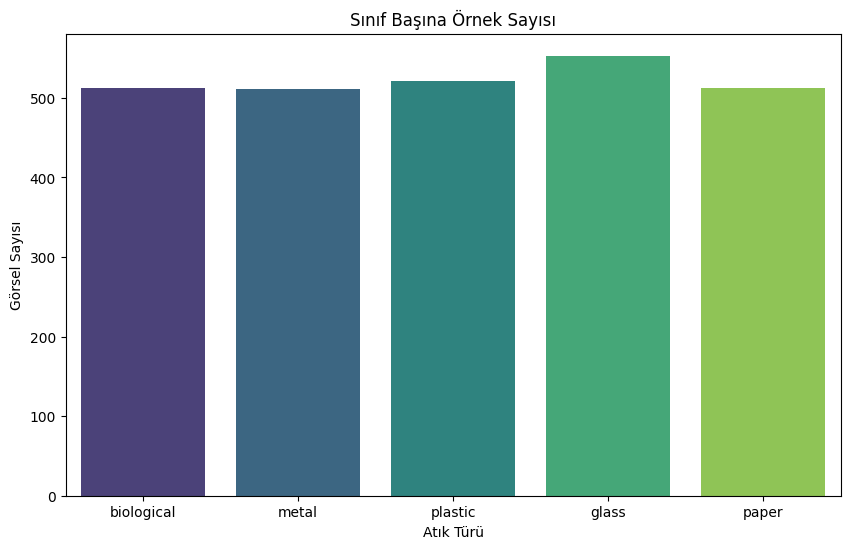

Grafik kaydedildi: /content/drive/MyDrive/ML_PROJE/outputs/figures/sinif_dagilimi.png

Eğitim: 2087
Doğrulama: 260
Test: 262


In [ ]:
import os
import torch
import matplotlib.pyplot as plt
import seaborn as sns
from torchvision import datasets, transforms

BASE_DIR = "/content/drive/MyDrive/ML_PROJE"

data_dir = os.path.join(BASE_DIR, "data", "raw")
output_dir = os.path.join(BASE_DIR, "outputs", "figures")
model_dir = os.path.join(BASE_DIR, "outputs", "models")

os.makedirs(output_dir, exist_ok=True)
os.makedirs(model_dir, exist_ok=True)

classes = os.listdir(data_dir)

class_counts = {
    cls: len(os.listdir(os.path.join(data_dir, cls)))
    for cls in classes
}

print("Veri Seti Özeti:")
for cls, count in class_counts.items():
    print(f"- {cls}: {count} örnek")

plt.figure(figsize=(10, 6))
sns.barplot(
    x=list(class_counts.keys()),
    y=list(class_counts.values()),
    palette="viridis"
)

plt.title("Sınıf Başına Örnek Sayısı")
plt.xlabel("Atık Türü")
plt.ylabel("Görsel Sayısı")

save_path = os.path.join(output_dir, "sinif_dagilimi.png")
plt.savefig(save_path)

plt.show()

data_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(15),
    transforms.ToTensor(),
    transforms.Normalize(
        [0.485, 0.456, 0.406],
        [0.229, 0.224, 0.225]
    )
])

full_dataset = datasets.ImageFolder(
    root=data_dir,
    transform=data_transforms
)

train_size = int(0.7 * len(full_dataset))
val_size = int(0.15 * len(full_dataset))
test_size = len(full_dataset) - train_size - val_size

train_data, val_data, test_data = torch.utils.data.random_split(
    full_dataset, [train_size, val_size, test_size]
)

print(f"\nEğitim: {len(train_data)}")
print(f"Doğrulama: {len(val_data)}")
print(f"Test: {len(test_data)}")

Epoch [1/5], Loss: 1.7886, Accuracy: 36.83%
Epoch [2/5], Loss: 1.4039, Accuracy: 37.34%
Epoch [3/5], Loss: 1.3752, Accuracy: 31.97%
Epoch [4/5], Loss: 1.3488, Accuracy: 40.15%
Epoch [5/5], Loss: 1.3624, Accuracy: 37.60%


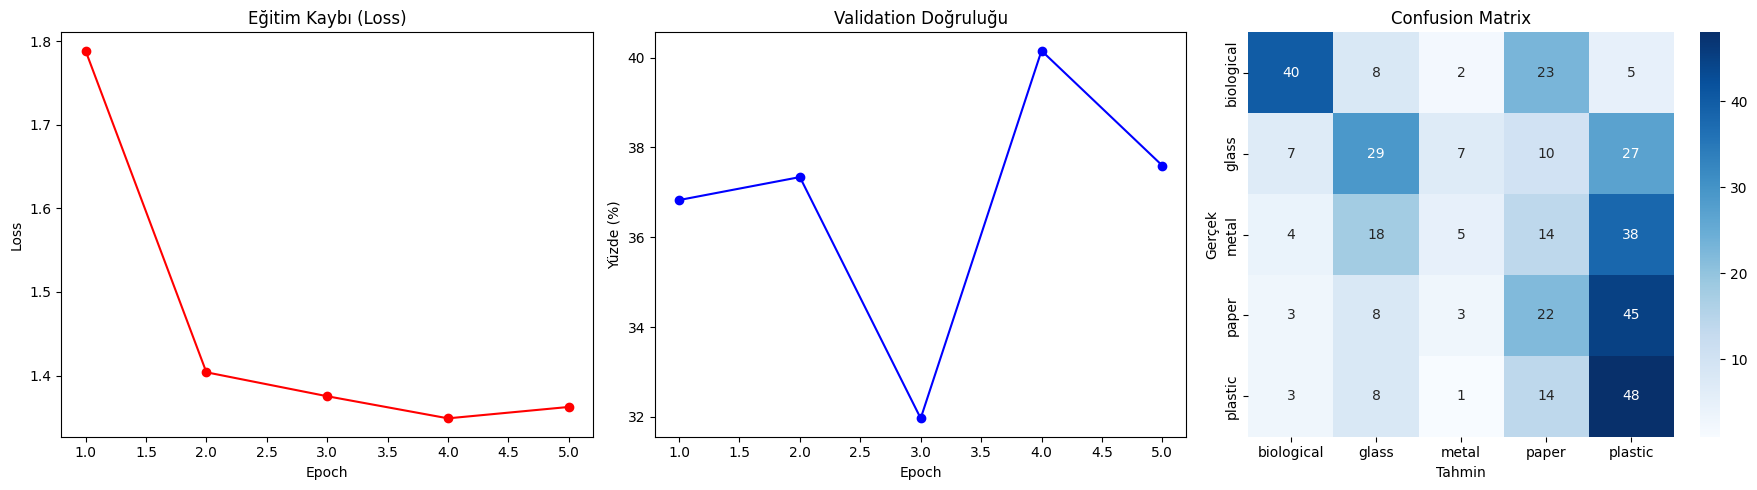

In [ ]:

import random
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, random_split
from sklearn.metrics import confusion_matrix

SEED = 42
random.seed(SEED)
torch.manual_seed(SEED)

num_epochs = 5
batch_size = 64
learning_rate = 0.01

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

data_dir = "/content/drive/MyDrive/ML_PROJE/data/raw"

train_transform = transforms.Compose([
    transforms.Resize((32, 32)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
])

test_transform = transforms.Compose([
    transforms.Resize((32, 32)),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
])

full_dataset_train = datasets.ImageFolder(root=data_dir, transform=train_transform)
full_dataset_test  = datasets.ImageFolder(root=data_dir, transform=test_transform)

classes = full_dataset_train.classes

train_size = int(0.70 * len(full_dataset_train))
val_size = int(0.15 * len(full_dataset_train))
test_size = len(full_dataset_train) - train_size - val_size

g = torch.Generator().manual_seed(SEED)

train_subset_idx, val_subset_idx, test_subset_idx = random_split(
    range(len(full_dataset_train)), [train_size, val_size, test_size], generator=g
)

train_indices = list(train_subset_idx)
val_indices   = list(val_subset_idx)
test_indices  = list(test_subset_idx)

train_data = torch.utils.data.Subset(full_dataset_train, train_indices)
val_data   = torch.utils.data.Subset(full_dataset_test,  val_indices)
test_data  = torch.utils.data.Subset(full_dataset_test,  test_indices)

train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
val_loader   = DataLoader(val_data, batch_size=batch_size, shuffle=False)
test_loader  = DataLoader(test_data, batch_size=batch_size, shuffle=False)

class ConvNet(nn.Module):
    def __init__(self):
        super(ConvNet, self).__init__()
        self.conv_layers = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Conv2d(32, 64, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        self.fc_layers = nn.Sequential(
            nn.Linear(128 * 4 * 4, 512),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(512, 5)
        )

    def forward(self, x):
        x = self.conv_layers(x)
        x = x.reshape(x.size(0), -1)
        x = self.fc_layers(x)
        return x

model = ConvNet().to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

train_losses = []
val_accuracies = []

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        outputs = model(images)
        loss = criterion(outputs, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    train_losses.append(running_loss / len(train_loader))

    model.eval()
    correct, total = 0, 0
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)

            outputs = model(images)
            _, predicted = torch.max(outputs, 1)

            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    acc = 100 * correct / total
    val_accuracies.append(acc)

    print(f"Epoch [{epoch+1}/{num_epochs}] | Loss: {train_losses[-1]:.4f} | Val Acc: {acc:.2f}%")

all_preds = []
all_labels = []

model.eval()
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)

        _, predicted = torch.max(outputs, 1)

        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

plt.figure(figsize=(18, 5))

plt.subplot(1, 3, 1)
plt.plot(range(1, num_epochs + 1), train_losses, marker="o")
plt.title("Eğitim Kaybı (Loss)")
plt.xlabel("Epoch")
plt.ylabel("Loss")

plt.subplot(1, 3, 2)
plt.plot(range(1, num_epochs + 1), val_accuracies, marker="o")
plt.title("Validation Doğruluğu")
plt.xlabel("Epoch")
plt.ylabel("Yüzde (%)")

plt.subplot(1, 3, 3)
cm = confusion_matrix(all_labels, all_preds)
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=classes, yticklabels=classes)
plt.title("Confusion Matrix")
plt.xlabel("Tahmin")
plt.ylabel("Gerçek")

plt.tight_layout()
plt.show()


In [ ]:
epochs_list = [10, 15]
batch_list = [32, 64, 128]
lr_list = [0.01, 0.005, 0.001, 0.0005, 0.0001]

num_trials = 5
best_acc = 0.0
best_params = {}

g = torch.Generator().manual_seed(SEED)

for trial in range(num_trials):
    epochs = random.choice(epochs_list)
    batch = random.choice(batch_list)
    lr = random.choice(lr_list)

    print(f"\nDeneme {trial+1}/{num_trials}: Epoch={epochs}, Batch={batch}, LR={lr}")

    train_loader_t = DataLoader(train_data, batch_size=batch, shuffle=True, generator=g)
    val_loader_t   = DataLoader(val_data, batch_size=batch, shuffle=False)

    model = ConvNet().to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)

    for epoch in range(epochs):
        model.train()
        for images, labels in train_loader_t:
            images, labels = images.to(device), labels.to(device)

            outputs = model(images)
            loss = criterion(outputs, labels)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

    model.eval()
    correct, total = 0, 0
    with torch.no_grad():
        for images, labels in val_loader_t:
            images, labels = images.to(device), labels.to(device)

            outputs = model(images)
            _, predicted = torch.max(outputs, 1)

            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    current_acc = 100 * correct / total
    print(f"Validation Doğruluk: %{current_acc:.2f}")

    if current_acc > best_acc:
        best_acc = current_acc
        best_params = {"batch_size": batch, "lr": lr, "epochs": epochs}

print("\n" + "=" * 30)
print(f"EN İYİ VALIDATION SONUÇ: %{best_acc:.2f}")
print(f"Parametreler: {best_params}")

5 farklı kombinasyon denenecek...

Deneme 1/5: Epoch=15, Batch=32, LR=0.0005
Doğruluk: %69.16

Deneme 2/5: Epoch=10, Batch=128, LR=0.0001
Doğruluk: %54.60

Deneme 3/5: Epoch=15, Batch=32, LR=0.01
Doğruluk: %19.54

Deneme 4/5: Epoch=15, Batch=128, LR=0.01
Doğruluk: %52.68

Deneme 5/5: Epoch=15, Batch=64, LR=0.001
Doğruluk: %70.31

EN İYİ SONUÇ: %70.31
Parametreler: {'batch_size': 64, 'lr': 0.001, 'epochs': 15}


Epoch [1/15], Loss: 1.4445, Accuracy: 46.55%
Epoch [2/15], Loss: 1.3138, Accuracy: 54.99%
Epoch [3/15], Loss: 1.2199, Accuracy: 53.96%
Epoch [4/15], Loss: 1.1505, Accuracy: 56.52%
Epoch [5/15], Loss: 1.1180, Accuracy: 60.87%
Epoch [6/15], Loss: 1.0672, Accuracy: 60.61%
Epoch [7/15], Loss: 0.9977, Accuracy: 62.40%
Epoch [8/15], Loss: 0.9829, Accuracy: 61.64%
Epoch [9/15], Loss: 0.9032, Accuracy: 64.45%
Epoch [10/15], Loss: 0.8953, Accuracy: 65.22%
Epoch [11/15], Loss: 0.8536, Accuracy: 67.26%
Epoch [12/15], Loss: 0.8147, Accuracy: 69.57%
Epoch [13/15], Loss: 0.7793, Accuracy: 68.29%
Epoch [14/15], Loss: 0.7363, Accuracy: 69.31%
Epoch [15/15], Loss: 0.7335, Accuracy: 71.36%


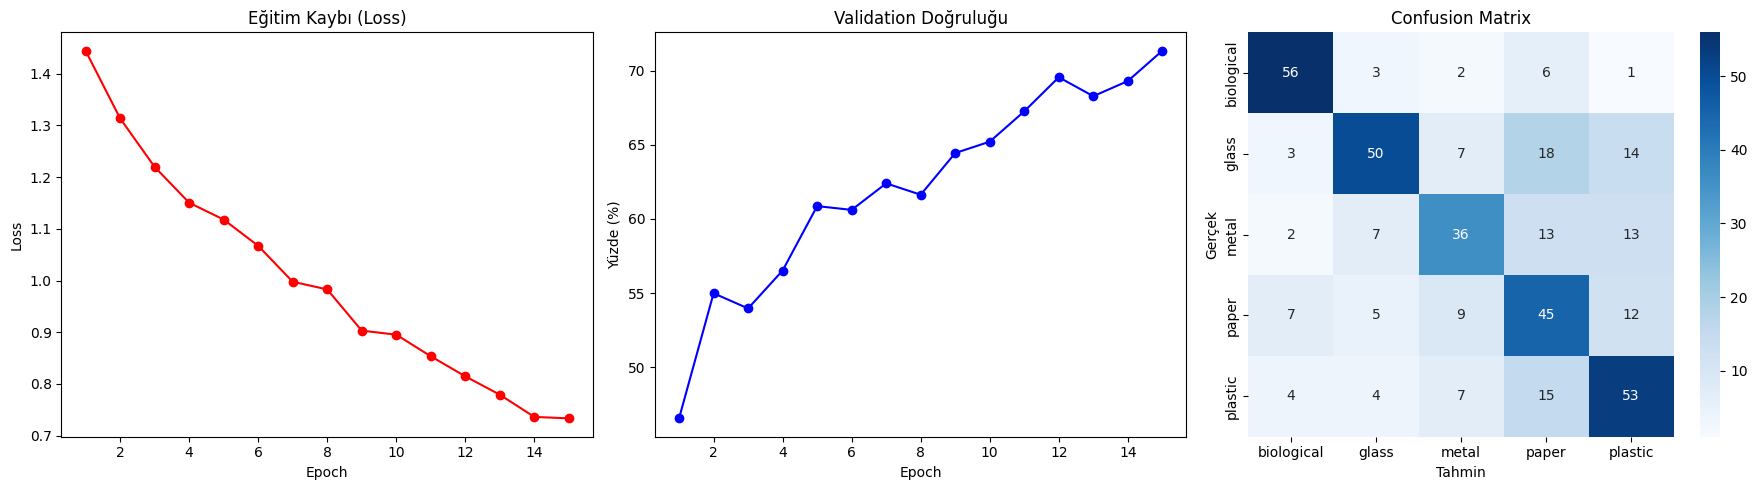

In [ ]:
num_epochs = 15
batch_size = 64
learning_rate = 0.001

train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
val_loader   = DataLoader(val_data, batch_size=batch_size, shuffle=False)
test_loader  = DataLoader(test_data, batch_size=batch_size, shuffle=False)

model = ConvNet().to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

train_losses = []
val_accuracies = []

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        outputs = model(images)
        loss = criterion(outputs, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    train_losses.append(running_loss / len(train_loader))

    model.eval()
    correct, total = 0, 0
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)

            outputs = model(images)
            _, predicted = torch.max(outputs, 1)

            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    acc = 100 * correct / total
    val_accuracies.append(acc)

    print(f"Epoch [{epoch+1}/{num_epochs}] | Loss: {train_losses[-1]:.4f} | Val Acc: {acc:.2f}%")

all_preds = []
all_labels = []

model.eval()
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)

        outputs = model(images)
        _, predicted = torch.max(outputs, 1)

        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

correct = sum([p == l for p, l in zip(all_preds, all_labels)])
test_acc = 100 * correct / len(all_labels)
print(f"\nFINAL TEST DOĞRULUK: %{test_acc:.2f}")

plt.figure(figsize=(18, 5))

plt.subplot(1, 3, 1)
plt.plot(range(1, num_epochs + 1), train_losses, marker="o")
plt.title("Eğitim Kaybı (Loss)")
plt.xlabel("Epoch")
plt.ylabel("Loss")

plt.subplot(1, 3, 2)
plt.plot(range(1, num_epochs + 1), val_accuracies, marker="o")
plt.title("Validation Doğruluğu")
plt.xlabel("Epoch")
plt.ylabel("Yüzde (%)")

plt.subplot(1, 3, 3)
cm = confusion_matrix(all_labels, all_preds)
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=classes, yticklabels=classes)
plt.title("Confusion Matrix")
plt.xlabel("Tahmin")
plt.ylabel("Gerçek")

plt.tight_layout()
plt.show()

ResNet-18 ile özellikler çıkarılıyor...
XGBoost eğitiliyor. Giriş boyutu: (1826, 512)

ResNet18 + XGBoost Doğruluğu: %89.03


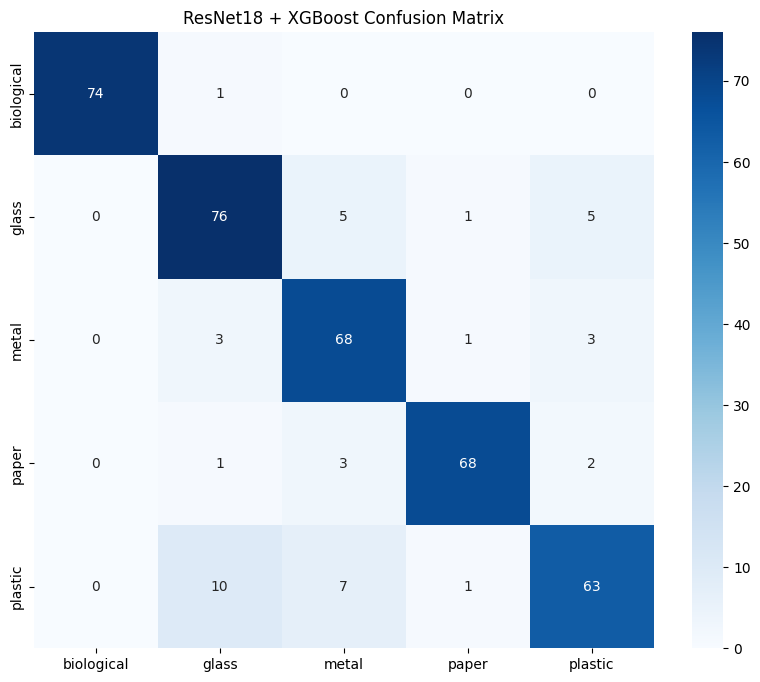

In [ ]:
# RESNET18 (FEATURE) + XGBOOST (CLASSIFIER)
# Burada ResNet18'i feature extractor gibi kullanıp XGBoost'a giriş veriyoruz

from xgboost import XGBClassifier
from torchvision import models
from sklearn.metrics import accuracy_score

device = device if "device" in globals() else torch.device("cuda" if torch.cuda.is_available() else "cpu")
data_dir = data_dir if "data_dir" in globals() else "/content/drive/MyDrive/ML_PROJE/data/raw"
SEED = SEED if "SEED" in globals() else 42

resnet_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

full_dataset = datasets.ImageFolder(root=data_dir, transform=resnet_transform)

train_size = int(0.70 * len(full_dataset))
val_size   = int(0.15 * len(full_dataset))
test_size  = len(full_dataset) - train_size - val_size

g = torch.Generator().manual_seed(SEED)

train_data, _, test_data = random_split(full_dataset, [train_size, val_size, test_size], generator=g)

train_loader = DataLoader(train_data, batch_size=32, shuffle=False)
test_loader  = DataLoader(test_data, batch_size=32, shuffle=False)

resnet18 = models.resnet18(weights=models.ResNet18_Weights.IMAGENET1K_V1).to(device)

for param in resnet18.parameters():
    param.requires_grad = False

resnet18.fc = nn.Identity()
resnet18.eval()

def extract_features(loader):
    features_list = []
    labels_list = []

    with torch.no_grad():
        for images, labels in loader:
            images = images.to(device)

            feats = resnet18(images)
            features_list.append(feats.cpu().numpy())
            labels_list.append(labels.numpy())

    return np.concatenate(features_list), np.concatenate(labels_list)

print("ResNet-18 ile özellikler çıkarılıyor...")
X_train, y_train = extract_features(train_loader)
X_test,  y_test  = extract_features(test_loader)

print(f"XGBoost eğitiyoruz. Feature boyutu: {X_train.shape}")

xgb_model = XGBClassifier(
    n_estimators=100,
    learning_rate=0.1,
    max_depth=6,
    objective="multi:softprob",
    tree_method="hist",
    device="cuda" if torch.cuda.is_available() else "cpu",
    random_state=42
)

xgb_model.fit(X_train, y_train)

y_pred = xgb_model.predict(X_test)
acc = accuracy_score(y_test, y_pred)

print("\n" + "=" * 30)
print(f"ResNet18 + XGBoost Doğruluğu: %{acc * 100:.2f}")
print("=" * 30)

plt.figure(figsize=(10, 8))
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(
    cm, annot=True, fmt="d", cmap="Blues",
    xticklabels=full_dataset.classes, yticklabels=full_dataset.classes
)
plt.title("ResNet18 + XGBoost Confusion Matrix")
plt.xlabel("Tahmin")
plt.ylabel("Gerçek")
plt.show()

/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch [1/15] | Loss: 1.1853 | Val Acc: 73.15%
Epoch [2/15] | Loss: 0.7140 | Val Acc: 79.03%
Epoch [3/15] | Loss: 0.5466 | Val Acc: 83.89%
Epoch [4/15] | Loss: 0.4668 | Val Acc: 81.84%
Epoch [5/15] | Loss: 0.4319 | Val Acc: 83.89%
Epoch [6/15] | Loss: 0.4030 | Val Acc: 84.91%
Epoch [7/15] | Loss: 0.3668 | Val Acc: 85.93%
Epoch [8/15] | Loss: 0.3523 | Val Acc: 85.17%
Epoch [9/15] | Loss: 0.3352 | Val Acc: 84.40%
Epoch [10/15] | Loss: 0.3401 | Val Acc: 87.47%
Epoch [11/15] | Loss: 0.3153 | Val Acc: 85.42%
Epoch [12/15] | Loss: 0.2981 | Val Acc: 84.65%
Epoch [13/15] | Loss: 0.2898 | Val Acc: 84.91%
Epoch [14/15] | Loss: 0.2799 | Val Acc: 88.49%
Epoch [15/15] | Loss: 0.2713 | Val Acc: 87.47%


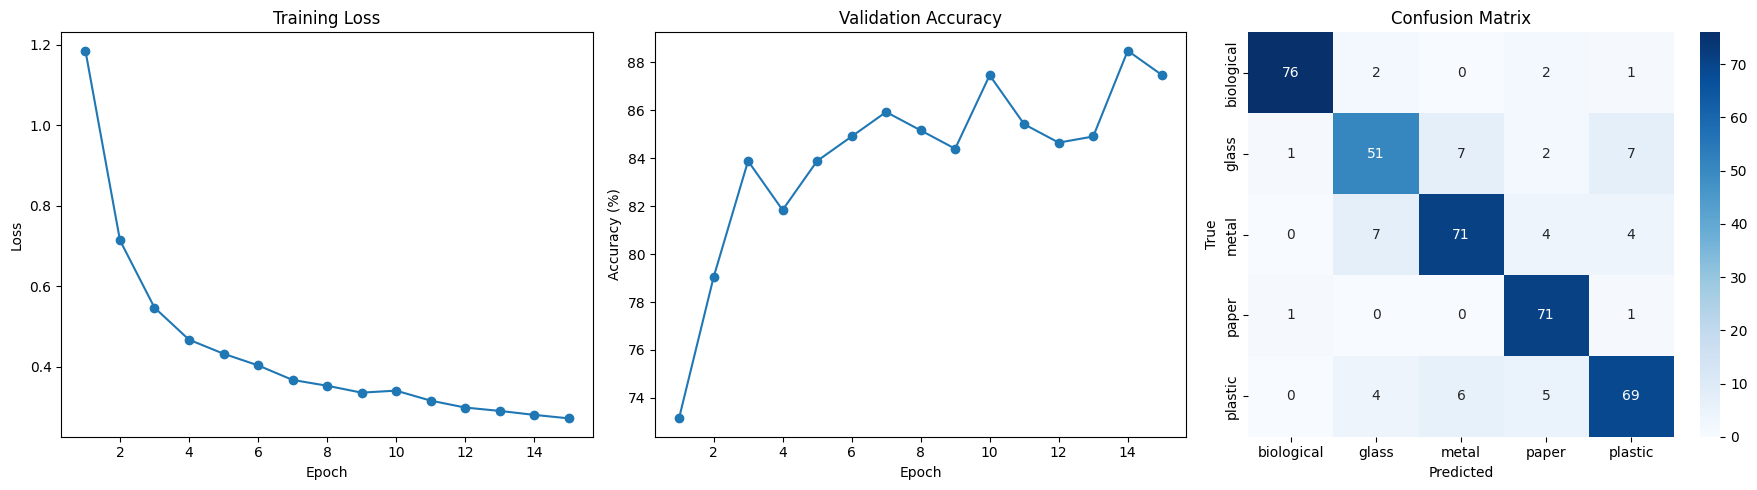

In [ ]:

num_epochs = 15
batch_size = 64
learning_rate = 0.001

transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
    ),
])

full_dataset = datasets.ImageFolder(root=data_dir, transform=transform)
classes = full_dataset.classes

train_size = int(0.70 * len(full_dataset))
val_size = int(0.15 * len(full_dataset))
test_size = len(full_dataset) - train_size - val_size

train_data, val_data, test_data = random_split(
    full_dataset, [train_size, val_size, test_size]
)

train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_data, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=False)

model = models.resnet18(pretrained=True)

for param in model.parameters():
    param.requires_grad = False

num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, 5)

model = model.to(device)

criterion = nn.CrossEntropyLoss()

optimizer = optim.Adam(model.fc.parameters(), lr=learning_rate)

train_losses = []
val_accuracies = []

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        outputs = model(images)
        loss = criterion(outputs, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    train_losses.append(running_loss / len(train_loader))

    model.eval()
    correct, total = 0, 0

    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)

            outputs = model(images)
            _, predicted = torch.max(outputs, 1)

            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    acc = 100 * correct / total
    val_accuracies.append(acc)

    print(f"Epoch [{epoch+1}/{num_epochs}] | Loss: {train_losses[-1]:.4f} | Val Acc: {acc:.2f}%")

all_preds = []
all_labels = []

model.eval()
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)

        outputs = model(images)
        _, predicted = torch.max(outputs, 1)

        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

plt.figure(figsize=(18, 5))

plt.subplot(1, 3, 1)
plt.plot(range(1, num_epochs + 1), train_losses, marker='o')
plt.title("Training Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")

plt.subplot(1, 3, 2)
plt.plot(range(1, num_epochs + 1), val_accuracies, marker='o')
plt.title("Validation Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy (%)")

plt.subplot(1, 3, 3)
cm = confusion_matrix(all_labels, all_preds)
sns.heatmap(
    cm, annot=True, fmt='d', cmap='Blues',
    xticklabels=classes,
    yticklabels=classes
)
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")

plt.tight_layout()
plt.show()

1/2: Standart ResNet-18 Eğitimi Başlıyor...


/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


2/2: ResNet-18 + XGBoost Hibrit Model Başlıyor...


/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
/tmp/ipython-input-2036921815.py:106: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=models_names, y=accuracies, palette='viridis')
/tmp/ipython-input-2036921815.py:113: FutureWarning: 

Passing `palette` without assigning `h

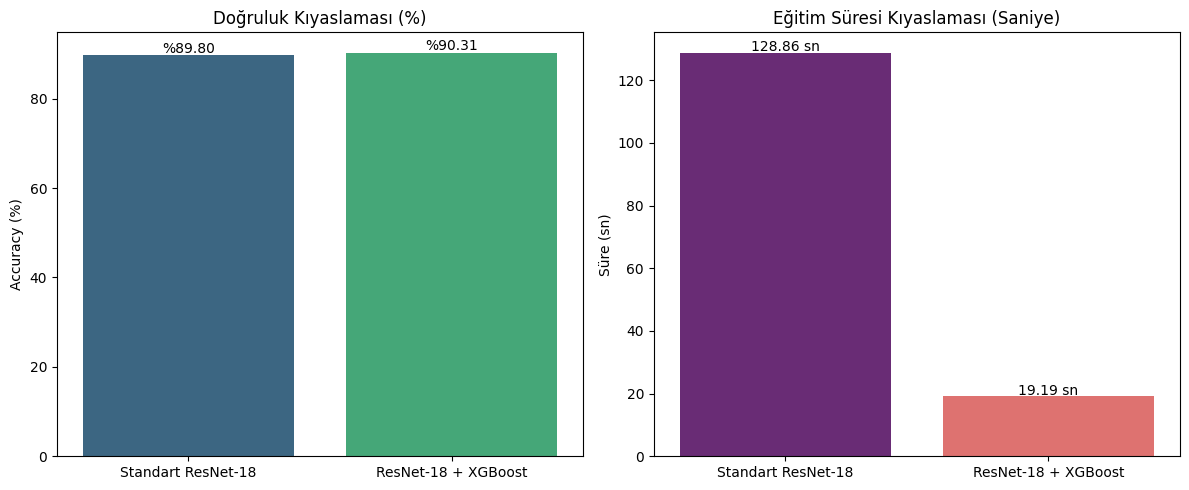


Sonuç Özet:
ResNet-18 -> Doğruluk: %89.80, Süre: 128.86 sn
Hybrid -> Doğruluk: %90.31, Süre: 19.19 sn


In [ ]:
import time
import numpy as np

batch_size = 64
train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
test_loader  = DataLoader(test_data, batch_size=batch_size, shuffle=False)

resnet_start = time.time()

print("1/2: Standart ResNet-18 başlıyor...")

model_resnet = models.resnet18(pretrained=True).to(device)

for p in model_resnet.parameters():
    p.requires_grad = False

model_resnet.fc = nn.Linear(model_resnet.fc.in_features, 5).to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model_resnet.fc.parameters(), lr=0.001)

for epoch in range(10):
    model_resnet.train()
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        outputs = model_resnet(images)
        loss = criterion(outputs, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

resnet_time = time.time() - resnet_start

model_resnet.eval()
resnet_preds, resnet_labels = [], []

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)

        outputs = model_resnet(images)
        _, predicted = torch.max(outputs, 1)

        resnet_preds.extend(predicted.cpu().numpy())
        resnet_labels.extend(labels.cpu().numpy())

resnet_acc = accuracy_score(resnet_labels, resnet_preds) * 100

print("2/2: ResNet-18 + XGBoost başlıyor...")

hybrid_start = time.time()

model_feat = models.resnet18(pretrained=True).to(device)

for p in model_feat.parameters():
    p.requires_grad = False

model_feat.fc = nn.Identity()
model_feat.eval()

def get_features(loader):
    feats, lbls = [], []
    with torch.no_grad():
        for imgs, ls in loader:
            imgs = imgs.to(device)
            out = model_feat(imgs)
            feats.append(out.cpu().numpy())
            lbls.append(ls.numpy())
    return np.concatenate(feats), np.concatenate(lbls)

X_train, y_train = get_features(train_loader)
X_test, y_test   = get_features(test_loader)

xgb = XGBClassifier(
    n_estimators=100,
    learning_rate=0.1,
    max_depth=6,
    objective="multi:softprob",
    tree_method="hist",
    device="cuda" if torch.cuda.is_available() else "cpu",
    random_state=42
)

xgb.fit(X_train, y_train)

y_pred_xgb = xgb.predict(X_test)
hybrid_acc = accuracy_score(y_test, y_pred_xgb) * 100

hybrid_time = time.time() - hybrid_start

models_names = ["Standart ResNet-18", "ResNet-18 + XGBoost"]
accuracies = [resnet_acc, hybrid_acc]
durations = [resnet_time, hybrid_time]

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
sns.barplot(x=models_names, y=accuracies)
plt.title("Doğruluk Kıyaslaması (%)")
plt.ylabel("Accuracy (%)")

for i, v in enumerate(accuracies):
    plt.text(i, v + 0.5, f"%{v:.2f}", ha="center")

plt.subplot(1, 2, 2)
sns.barplot(x=models_names, y=durations)
plt.title("Eğitim Süresi Kıyaslaması (sn)")
plt.ylabel("Süre (sn)")

for i, v in enumerate(durations):
    plt.text(i, v + 0.5, f"{v:.2f} sn", ha="center")

plt.tight_layout()
plt.show()

print("\nSonuç Özet:")
print(f"ResNet-18 -> Doğruluk: %{resnet_acc:.2f}, Süre: {resnet_time:.2f} sn")
print(f"Hybrid    -> Doğruluk: %{hybrid_acc:.2f}, Süre: {hybrid_time:.2f} sn")